In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nb
from nibabel.freesurfer.io import read_geometry
from nilearn.plotting.surf_plotting import load_surf_data
from nilearn.plotting.surf_plotting import load_surf_mesh


In [2]:
import sys
sys.path.append('../../../BrainStat')
import brainstat
from brainstat.vis import surfaces


### visualize white matter surface

In [3]:
SW_surf_L = read_geometry('../vis/fsaverage5/lh.white')
SW_surf_R = read_geometry('../vis/fsaverage5/rh.white')

SW = {}
SW['coords'] = np.concatenate((SW_surf_L[0], SW_surf_R[0]))
SW['tri']    = np.concatenate((SW_surf_L[1], SW_surf_R[1]))

Fs_Bg_Map_L  = load_surf_data('../vis/fsaverage5/lh.sulc')
Fs_Bg_Map_R = load_surf_data('../vis/fsaverage5/rh.sulc')

BG_MAP = np.concatenate((Fs_Bg_Map_L, Fs_Bg_Map_R))




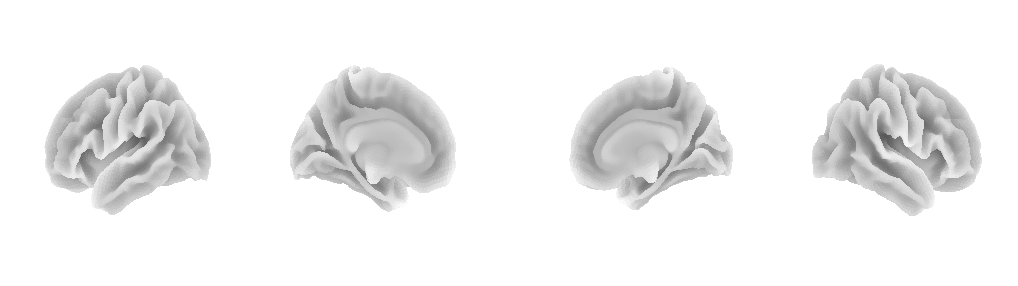

In [4]:
fig01 = surfaces.plot_surfstat(SW, BG_MAP)

### visualize gray matter pial surface

In [5]:
Fs_Mesh_L = read_geometry('../vis/fsaverage5/lh.pial')
Fs_Mesh_R = read_geometry('../vis/fsaverage5/rh.pial')


SURF_MESH = {}
SURF_MESH['coords'] = np.concatenate((Fs_Mesh_L[0], Fs_Mesh_R[0]))
SURF_MESH['tri']    = np.concatenate((Fs_Mesh_L[1], Fs_Mesh_R[1]))


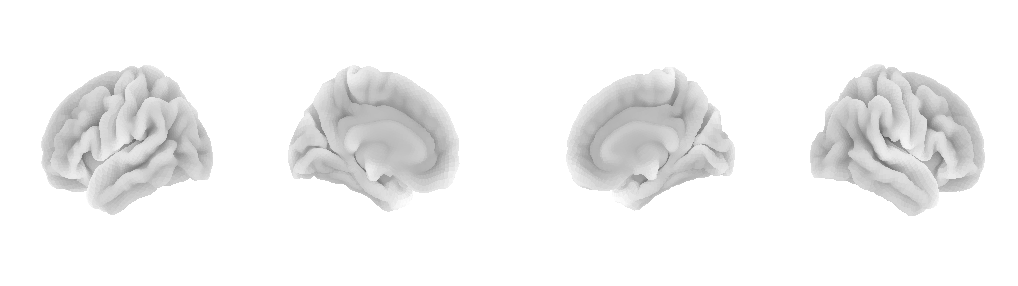

In [6]:
fig02 = surfaces.plot_surfstat(SURF_MESH, BG_MAP)


### load tutorial thickness data and visualize the mean thickness

In [7]:
from utils import fetch_tutorial_data

a = fetch_tutorial_data(n_subjects = 259, 
                        data_dir = 'data')



Dataset created in data/brainstat_tutorial



 ...done. (2 seconds, 0 min)


Downloaded 4390912 of 19209132 bytes (22.9%,    3.4s remaining) ...done. (3 seconds, 0 min)
Extracting data from data/brainstat_tutorial/1870c0ea85cdd492a3f6a87f9e929257/brainstat_tutorial.zip..... done.


In [8]:
import nibabel.freesurfer.mghformat as mgh

thickness = np.zeros((259, 20484))

j = 0
for i in range(0,259):
  
    sub_T_data_L = mgh.load(a['image_files'][j]).get_fdata()
    sub_T_data_R = mgh.load(a['image_files'][j+1]).get_fdata()

    sub_T_arr_L = np.array(sub_T_data_L)
    sub_T_arr_R = np.array(sub_T_data_R)

    subj_T = np.concatenate((sub_T_arr_L[:,:,0], sub_T_arr_R[:,:,0])).T
    
    if j == 0:
        thickness = subj_T
    else:
        thickness = np.concatenate((thickness, subj_T), axis=0)
    
    j += 2

In [9]:
thickness.shape

(259, 20484)

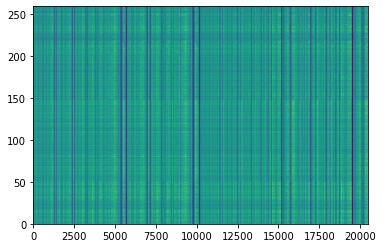

In [10]:
plt.imshow(thickness, extent=[0,20484,0,259], aspect='auto')

In [11]:
Mean_thickness = thickness.mean(axis=0)
Mean_thickness.shape

(20484,)

In [12]:
# get the medial wall masks

Mask_Left  = nb.freesurfer.io.read_label('../vis/fsaverage5/lh.cortex.label')
Mask_Right = nb.freesurfer.io.read_label('../vis/fsaverage5/rh.cortex.label')

MASK   = np.concatenate((Mask_Left,  10242 + Mask_Right))


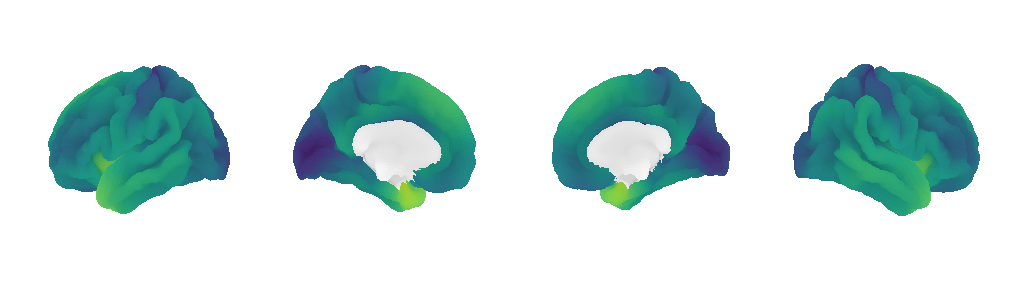

In [13]:
# mean thickness across the pial surface

fig03 = surfaces.plot_surfstat(SURF_MESH, 
                               BG_MAP,
                               Mean_thickness, 
                               mask = MASK,
                               cmap = 'viridis',
                               vmin = 1.5,
                               vmax = 4)

### BrainStat

In [14]:
from brainstat.stats.models import linear_model
from brainstat.stats.models import t_test
from brainstat.stats.terms import Term


In [16]:
### here we go...

# get the AGE 
AGE = np.array(a['demographics']['AGE'])

# code some variables of interest
AGE_term = Term(AGE)

# build a model
M = 1 + AGE_term

# estimate the model parameter slm
slm = linear_model(thickness, M, SW); 

# specify the contrast
slm = t_test(slm, -AGE)

In [17]:
# get the T-values

Tvals = np.array(slm['t'])
Tvals = Tvals.flatten()
Tvals.shape, Tvals.min(), Tvals.max()

((20484,), -1.9378904840608315, 13.932338220641416)

### plot the T-values across the cortex

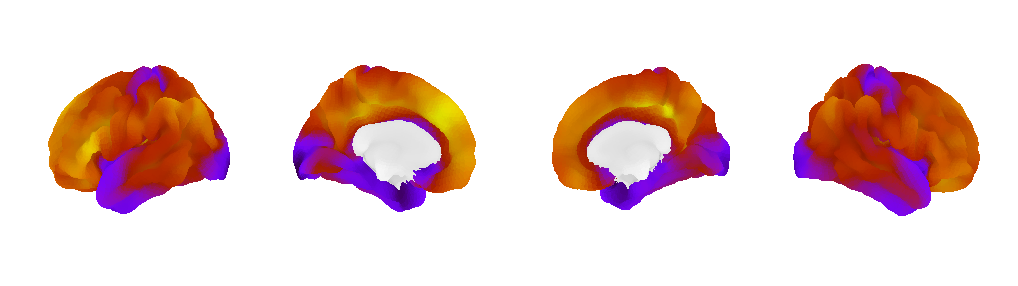

In [18]:
fig04 = surfaces.plot_surfstat(SURF_MESH, 
                               BG_MAP,
                               Tvals, 
                               mask = MASK,
                               cmap = 'gnuplot',
                               vmin = Tvals.min(),
                               vmax = Tvals.max())